In [1]:
%load_ext autoreload

%autoreload 2

## Learning Improvement Heuristics for Solving the Travelling Salesman Problem (13)

Задача состояла в воспроизведении результатов статьи https://arxiv.org/pdf/1912.05784v1.pdf. Статья посвящена улучшению имеющихся решений проблемы коммивояжера с евклидовыми расстояниями между точками с использованием обучения с подкреплением. Были написаны среда и модель для проведения экспериментов. Был написан модуль обучения, но в проведенных экспериментах не получилось достичь точности рассматриваемых авторами solver'ов. Сравнение проивзодилось с API от компании Google OR-Tools.

### Постановка задачи
Опишем среду, действия и награды:
1. Множество состояний среды - множество всевозможных перестановок $n$ точек. 
2. Действия - обращения порядка следования точек в заданной перестановке между двумя выбранными точками.
3. Награда - в случае уменьшения суммарного расстояния между точками - разница между суммарным расстоянием до изменения и после, в случае увеличения/не изменения - ноль. 

В качестве алгоритма обучения использовался Actor-Critic с forward-view равным $k$. 

In [2]:
from src.architectures import Actor, Critic
from src.environment import TSPEnv
from src.train import train, train_one_batch
from src.heuristics import compute_distance
from src.utils import sample_nodes

import torch
import numpy as np

from matplotlib import pyplot as plt

from src.presentation import test_metric_by_graph_size

import pandas as pd

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Использованные гиперпараметры

Размер графа - 20 точек. Для каждой эпохи генерируется 10240 графа (batch_size=256). Всего 200 эпох. Learning rate для оптимизатора Adam - $10^{-4}$. Дисконтирующий множетель наград - 0.99. Число шагов в farward-view - 4. Длительность улучшения решения - 200 шагов.

In [ ]:
batch_size = 256
TSP_size = 20

In [ ]:
actor = Actor().to(device)
critic = Critic(batch_size=batch_size, n=TSP_size).to(device)

In [ ]:
#actor.train()
#critic.train()

In [ ]:
%%time
train_one_batch(actor, critic, device, batch_size=batch_size, epochs=1, TSP_size=TSP_size, batch_times=40)

In [ ]:
%%time
train(actor, critic, device, batch_size=batch_size, epochs=200, TSP_size=TSP_size, batch_times=40)

In [ ]:
torch.save(actor, 'actor_20_new')

In [ ]:
torch.save(critic, 'critic_20_new')

### Сравнение на новом графе

Случайно инициализированный граф, на котором в течение 5000 шагов производится улучшение случайного начального.

In [19]:
actor = torch.load('actor_50_new')
actor.eval()

Actor(
  (linear_embedding): LinearEmbedding(
    (projection): Linear(in_features=2, out_features=128, bias=True)
  )
  (encoder): Encoder(
    (encoder_layers): ModuleList(
      (0): EncoderLayer(
        (s_att): AttentionLayer(
          (linear_v): Linear(in_features=128, out_features=128, bias=True)
          (linear_q): Linear(in_features=128, out_features=128, bias=True)
          (linear_k): Linear(in_features=128, out_features=128, bias=True)
        )
        (batch_norm_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (batch_norm_2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (ff): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=128, bias=True)
        )
      )
      (1): EncoderLayer(
        (s_att): AttentionLayer(
          (linear_v): Linear(in_features=128, out_features=128

In [20]:
n_space = np.arange(41, 60)

In [21]:
results_41_59 = test_metric_by_graph_size(actor, n_space, number_of_graphs=256, window=5000, device='cuda')

100%|██████████████████████████████████████████████████████████████████████████████| 19/19 [8:06:47<00:00, 1537.26s/it]


In [22]:
pd.DataFrame(results_41_59).to_csv('results_41_59.csv')

In [29]:
pd.DataFrame(results_41_59)

,0,1,2,3,4
0,6.360218,6.142741,5.871025,5.211498,5.424108
1,6.424158,6.194273,5.947962,5.276341,5.488276
2,6.478531,6.276681,6.040464,5.321423,5.445355
3,6.600639,6.364800,6.097294,5.393400,5.556773
4,6.661191,6.431020,6.177984,5.448217,5.631172
5,6.751721,6.524958,6.279281,5.521636,5.680986
6,6.797436,6.596697,6.288920,5.562431,5.688661
7,6.831404,6.633239,6.362226,5.591525,5.745773
8,6.902143,6.698092,6.453309,5.654195,5.739953
9,7.021567,6.768352,6.518591,5.724924,5.722515


### Сравнение на новом графе

In [23]:
actor = torch.load('actor_20_new')
actor.eval()

Actor(
  (linear_embedding): LinearEmbedding(
    (projection): Linear(in_features=2, out_features=128, bias=True)
  )
  (encoder): Encoder(
    (encoder_layers): ModuleList(
      (0): EncoderLayer(
        (s_att): AttentionLayer(
          (linear_v): Linear(in_features=128, out_features=128, bias=True)
          (linear_q): Linear(in_features=128, out_features=128, bias=True)
          (linear_k): Linear(in_features=128, out_features=128, bias=True)
        )
        (batch_norm_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (batch_norm_2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (ff): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=128, bias=True)
        )
      )
      (1): EncoderLayer(
        (s_att): AttentionLayer(
          (linear_v): Linear(in_features=128, out_features=128

In [24]:
n_space = np.arange(11, 30)

In [25]:
results_11_29 = test_metric_by_graph_size(actor, n_space, number_of_graphs=256, window=5000, device='cuda')

100%|██████████████████████████████████████████████████████████████████████████████| 19/19 [7:11:03<00:00, 1361.26s/it]


In [26]:
pd.DataFrame(results_11_29).to_csv('results_11_29.csv')

In [41]:
pd.DataFrame(results_11_29)

,0,1,2,3,4
0,3.325303,3.152916,3.048950,2.956632,2.966594
1,3.453712,3.338311,3.191310,3.085769,3.111881
2,3.598899,3.467672,3.311438,3.189716,3.201872
3,3.760404,3.638880,3.472667,3.322840,3.338587
4,3.941111,3.756387,3.608352,3.414094,3.429301
5,4.067076,3.867279,3.728955,3.504659,3.511568
6,4.210791,4.024393,3.846910,3.607266,3.612112
7,4.296149,4.104749,3.907734,3.658872,3.662234
8,4.397482,4.224727,3.976829,3.753108,3.754670
9,4.501179,4.317364,4.094124,3.832907,3.833010


### Генерация датасетов

In [31]:
for n in np.arange(20, 90, 10):
    env = TSPEnv(n=n, batch_size=256)
    env.save_graph("dataset_"+str(n)+".pkl")

### Графики обощения

In [43]:
from matplotlib import pyplot as plt

In [59]:
df_50 = pd.read_csv('./results/results_50.csv', index_col=0)
df_20 = pd.read_csv('./results/results_20.csv', index_col=0)
df_10_30 = pd.read_csv('./results/results_11_29.csv', index_col=0)
df_40_60 = pd.read_csv('./results/results_41_59.csv', index_col=0)

In [60]:
columns = ['nearest_neighbour', 'closest_heuristic', 'farthest_heuristic', 'or-tools', 'model']

In [65]:
index_50 = np.arange(20, 90, 10)
index_10_30 = np.arange(11, 30)
index_40_60 = np.arange(41, 60)

In [66]:
df_50.columns = columns
df_50.index = index_50
df_20.columns = columns
df_20.index = index_50
df_10_30.columns = columns
df_10_30.index = index_10_30
df_40_60.columns = columns
df_40_60.index = index_40_60

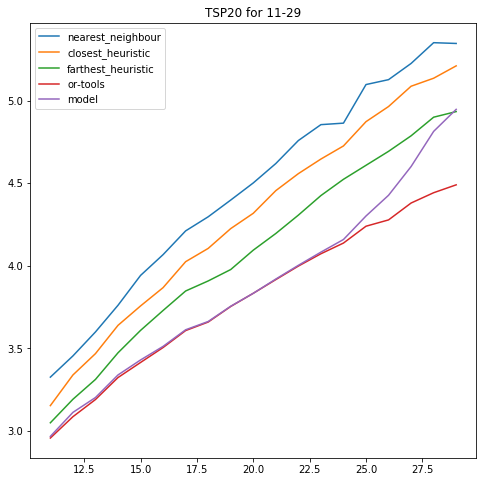

In [73]:
fig = plt.figure(figsize=(8,8))
plt.plot(df_10_30)
plt.title('TSP20 for 11-29')
plt.legend(columns)
plt.savefig('TSP20 for 11-29.png')

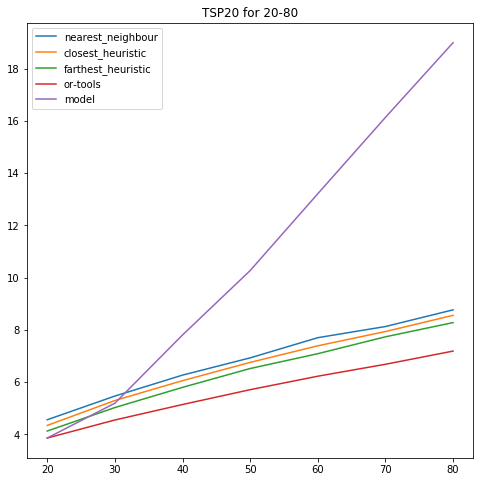

In [75]:
fig = plt.figure(figsize=(8,8))
plt.plot(df_20)
plt.title('TSP20 for 20-80')
plt.legend(columns)
plt.savefig('TSP20 for 20-80.png')

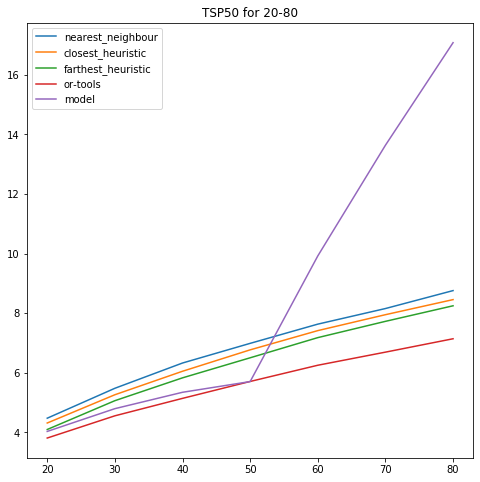

In [76]:
fig = plt.figure(figsize=(8,8))
plt.plot(df_50)
plt.title('TSP50 for 20-80')
plt.legend(columns)
plt.savefig('TSP50 for 20-80.png')

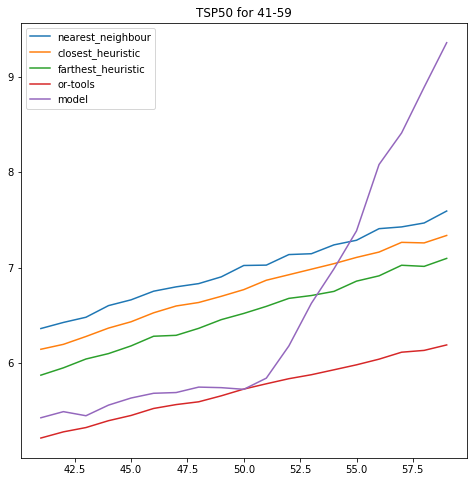

In [77]:
fig = plt.figure(figsize=(8,8))
plt.plot(df_40_60[])
plt.title('TSP50 for 41-59')
plt.legend(columns)
plt.savefig('TSP50 for 41-59.png')

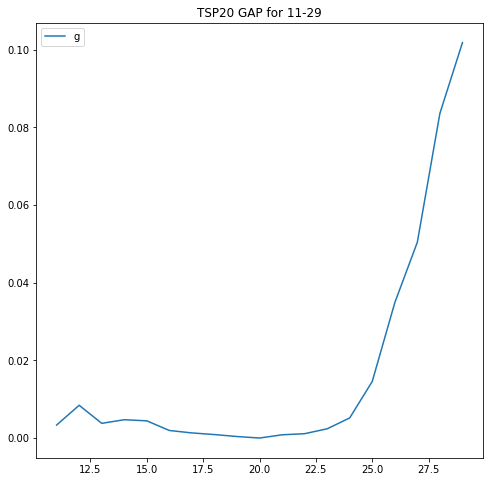

In [91]:
fig = plt.figure(figsize=(8,8))
plt.plot((df_10_30['model'] - df_10_30['or-tools'])/df_10_30['or-tools'])
plt.title('TSP20 GAP for 11-29')
plt.legend('gap for model')
plt.savefig('TSP20 GAP for 11-29.png')

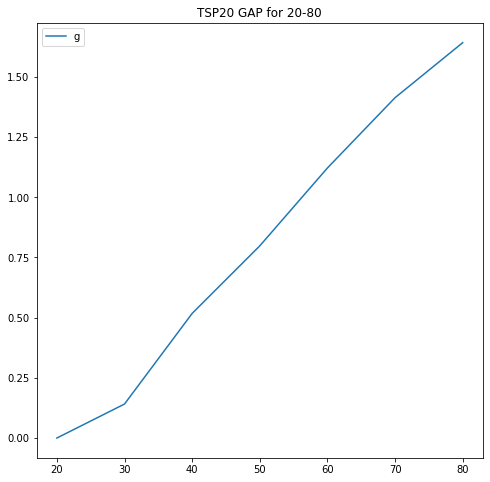

In [92]:
fig = plt.figure(figsize=(8,8))
plt.plot((df_20['model'] - df_20['or-tools'])/df_20['or-tools'])
plt.title('TSP20 GAP for 20-80')
plt.legend('gap for model')
plt.savefig('TSP20 GAP for 20-80.png')

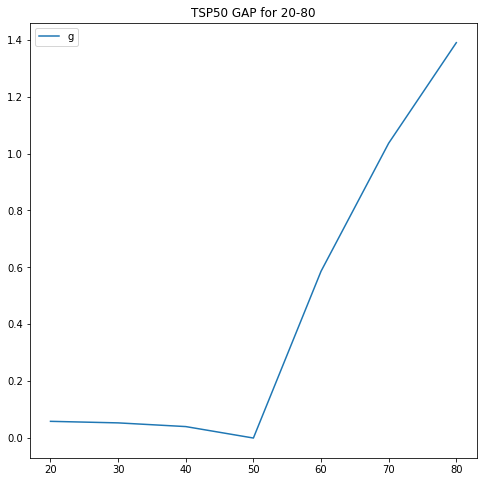

In [93]:
fig = plt.figure(figsize=(8,8))
plt.plot((df_50['model'] - df_50['or-tools'])/df_50['or-tools'])
plt.title('TSP50 GAP for 20-80')
plt.legend('gap for model')
plt.savefig('TSP50 GAP for 20-80.png')

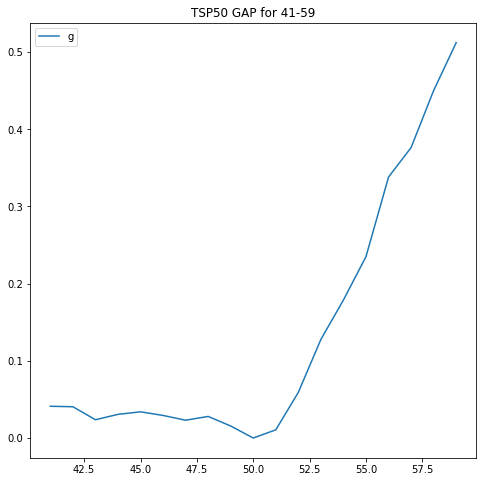

In [94]:
fig = plt.figure(figsize=(8,8))
plt.plot((df_40_60['model'] - df_40_60['or-tools'])/df_40_60['or-tools'])
plt.title('TSP50 GAP for 41-59')
plt.legend('gap for model')
plt.savefig('TSP50 GAP for 41-59.png')